In [1]:
import pandas as pd
import transformers 
import numpy as np
import torch
import torch.nn.functional as F
import datasets

from collections import OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt

import re
import sys

sys.path.insert(0, '..')

from decompose_gpt2 import GPT2ForSequenceClassificationDecomposed, GPT2Config
from build_masks import build_masks


### Load Model

In [2]:
labels = ['awareness', 'change_of_location', 'change_of_state',
       'change_of_possession', 'existed_after', 'existed_before',
       'existed_during', 'instigation', 'sentient', 'volition']

path = "../../combined_SPRL_distilgpt2"
model = transformers.AutoModelForSequenceClassification.from_pretrained(path)

new_state_dict = OrderedDict()
for key, value in model.state_dict().items():
    # ref : https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html
    new_key = key.replace("ln_1.weight", "ln_1.gamma").replace("ln_1.bias", "ln_1.beta")
    new_key = new_key.replace("ln_2.weight", "ln_2.gamma").replace("ln_2.bias", "ln_2.beta")
    new_key = new_key.replace("ln_f.weight", "ln_f.gamma").replace("ln_f.bias", "ln_f.beta")
    new_state_dict[new_key] = value


In [3]:
decomposed_model = GPT2ForSequenceClassificationDecomposed(
    config= GPT2Config.from_dict(model.config.to_dict()),
    debug=False, 
    num_labels=len(labels) * 3
    )

tokenizer = transformers.AutoTokenizer.from_pretrained(path + "/tokenizer")
decomposed_model.model.load_state_dict(new_state_dict)
decomposed_model.model.eval()


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln_1): LayerNorm((768,), eps=1e-05)
        (attn): Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05)
        (mlp): MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05)
  )
  (score): Linear(in_features=768, out_features=30, bias=False)
)

### Load Data

In [4]:
roles_wide = pd.read_csv("../../../dataV2/combined_V1_V2.csv", na_filter=False)
roles_wide.drop("Unnamed: 0", inplace=True, axis=1)

roles_wide.rename({"Sentence": "sentence", "Arg.Phrase": "arg"}, axis=1, inplace=True)

properties_list = ['awareness', 'change_of_location', 'change_of_state',
       'change_of_possession', 'existed_after', 'existed_before',
       'existed_during', 'instigation', 'sentient', 'volition']

print(roles_wide.shape)
roles_wide["combined_labels"] = roles_wide["combined_labels"].apply(lambda x: eval(x))
roles_wide.head()


(28810, 14)


,Sentence.ID,Gram.Func,sentence,Predicate,Split,arg,Arg.Stripped,arg_idx,verb_idx,structure,decomp_version,Pred.Lemma,modified_sentence,combined_labels
0,0003_21,nsubj,"In July , a gradual ban was imposed by the Env...",was imposed by,test,a gradual ban,a ban,"(3, 6)","(6, 9)",passive_full,V1,impose,1,"[1.0, 1.0, 3.0, 1.0, 5.0, 1.0, 5.0, 1.0, 1.0, ..."
1,0003_21,dobj,"In July , a gradual ban was imposed by the Env...",was imposed by,train,the Environmental Protection Agency,the Environmental Protection Agency,"(9, 13)","(6, 9)",passive_full,V1,impose,1,"[5.0, 1.0, 3.0, 1.0, 5.0, 5.0, 5.0, 5.0, 1.0, ..."
2,0003_29,nsubj,No bearing on our work force today is had by it .,is had by,train,No bearing on our work force today,no bearing,"(0, 7)","(7, 10)",passive_full,V1,have,1,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,0003_29,dobj,No bearing on our work force today is had by it .,is had by,test,it,It,"(10, 11)","(7, 10)",passive_full,V1,have,1,"[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 5.0, 3.0, 2.0, ..."
4,0003_9,nsubj,A team of researchers from the National Cancer...,was led by,train,A team of researchers from the National Cancer...,a team,"(0, 19)","(19, 22)",passive_full,V1,lead,1,"[5.0, 3.0, 3.0, 1.0, 3.0, 3.0, 5.0, 3.0, 1.0, ..."


In [5]:
eval_df = roles_wide.loc[
    (roles_wide["decomp_version"] == "V2") & \
    (roles_wide["Split"] == "test")
    # (roles_wide["modified_sentence"] == 0)
    ][["Pred.Lemma", "Gram.Func", "structure", "sentence", "Predicate", "arg_idx", "verb_idx", "arg", "Arg.Stripped"]].drop_duplicates().reset_index()

print(eval_df.shape)
eval_df


(639, 10)


,index,Pred.Lemma,Gram.Func,structure,sentence,Predicate,arg_idx,verb_idx,arg,Arg.Stripped
0,14299,raise,nsubj,active_full,A girl raises her hand .,raises,"(0, 2)","(2, 3)",A girl,A girl
1,14301,raise,dobj,active_full,A girl raises her hand .,raises,"(3, 5)","(2, 3)",her hand,the hand
2,14303,be,nsubj,active_full,""" I 'm afraid not , "" explains Winston , "" tha...",is,"(11, 12)","(12, 13)",that,that
3,14305,say,nsubj,active_full,"In a timid voice , he says : "" If an airplane ...",says,"(5, 6)","(6, 7)",he,he
4,14307,beam,nsubj,active_full,""" Wonderful ! "" Winston beams .",beams,"(4, 5)","(5, 6)",Winston,Winston
...,...,...,...,...,...,...,...,...,...,...
634,21896,enjoy,nsubj,passive_full,The animations were enjoyed by me and wanted t...,were enjoyed by,"(0, 2)","(2, 5)",The animations,the animations
635,21898,have,nsubj,passive_full,A Full Color Catalog and Wholesale Price List ...,is had by,"(0, 14)","(14, 17)",A Full Color Catalog and Wholesale Price List ...,a Color Catalog and Price List
636,21900,have,dobj,passive_full,A Full Color Catalog and Wholesale Price List ...,is had by,"(17, 18)","(14, 17)",us,We
637,21902,accecpt,nsubj,passive_full,"Visa , MasterCard , Amex , Dinner s Club / Car...",are accecpted by,"(0, 19)","(19, 22)","Visa , MasterCard , Amex , Dinner s Club / Car...",Visa MasterCard Amex the Club / Carte Blanche ...


### Make Contribution Masks and Process Sentences

In [6]:
dataset, eval_df, lengths = build_masks(eval_df, tokenizer).values()
dataset



arg:  her hand
stripped arg:  the hand
arg reconstructed (no mod):  her hand
mod reconstructed:  her

arg:  Our plans
stripped arg:  the plans
arg reconstructed (no mod):  Our plans
mod reconstructed:  Our

arg:  Walter Kistler, LTS co-founder and Chairman
stripped arg:  Kistler
arg reconstructed (no mod):  Walter Kistler, LTS co-founder and Chairman
mod reconstructed:  Walter LTS co-founder and Chairman

arg:  the letter, signed by NASA Administrator Mike Griffin and the Pentagon's top space official, ex-astronaut Ron Sega
stripped arg:  the letter signed
arg reconstructed (no mod):  the letter, signed by NASA Administrator Mike Griffin and the Pentagon's top space official, ex-astronaut Ron Sega
mod reconstructed:  by NASA Administrator Mike Griffin and the Pentagon's top space official, ex-astronaut Ron Sega

arg:  The Sunni AMS
stripped arg:  The AMS
arg reconstructed (no mod):  The Sunni AMS
mod reconstructed:  Sunni

arg:  the right idea
stripped arg:  the idea
arg reconstructed

[{'sentence': '<a>A girl<a><p> raises<p> her hand.',
  'index': 14299,
  'arg': 'A girl',
  'stripped_arg': 'A girl',
  'gram': 'nsubj',
  'structure': 'active_full',
  'modifier_mask': array([0, 0]),
  'arg_nomod_mask': array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0]),
  'arg_mod_mask': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  'pred_mask': array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])},
 {'sentence': 'A girl<p> raises<p><a> her hand<a>.',
  'index': 14301,
  'arg': 'her hand',
  'stripped_arg': 'the hand',
  'gram': 'dobj',
  'structure': 'active_full',
  'modifier_mask': array([1, 0]),
  'arg_nomod_mask': array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0]),
  'arg_mod_mask': array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
  'pred_mask': array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])},
 {'sentence': '"I \'m afraid not", explains Winston, "<a> that<a><p> is<p> what we would call a GREAT LOSS".',
  'index': 14303,
  'arg': 'that',
  'stripped_arg': 'that',
  'gram': 'nsubj',
  'structure': 'active_full',
  'modifier_mask': array([0]),
 

In [7]:
max(lengths)


74

### Analyze Contributions


In [8]:
max_length = 128

def tokenize_and_mask(t):
    encoded = tokenizer(t["sentence"], padding="max_length", truncation=True,
                        max_length=max_length, return_tensors="pt")
    beta_mask = np.pad(t["mask"], (0, max_length - len(t["mask"])%max_length), 'constant')
    beta_mask = torch.Tensor(beta_mask).to(int)
    beta_mask = torch.stack([beta_mask, 1 - beta_mask])
    encoded["beta_mask"] = beta_mask
    return encoded

test_set = datasets.Dataset.from_pandas(eval_df)
test_set = test_set.map(tokenize_and_mask)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Map:   0%|          | 0/1917 [00:00<?, ? examples/s]

In [9]:
# gen = test_set.iter(batch_size=4)
# with torch.no_grad():
#     for i, batch in enumerate(gen):
#         beta_mask = torch.Tensor(batch["beta_mask"]).to(torch.long)
#         attention_mask = torch.Tensor(batch["attention_mask"]).to(torch.long).squeeze(1)
#         input_ids = torch.Tensor(batch["input_ids"]).to(torch.long).squeeze(1)

#         l = decomposed_model(input_ids=input_ids,
#                             attention_mask=attention_mask,
#                             beta_mask=beta_mask,
#                             num_contributions=2)["logits"].numpy()
#         np.save(f"gcd_logits_distilgpt2/batch_{i}_logits.npy", l)
#         if i % 10 == 0:
#             print(i)


In [10]:
logits = []
for i in range(480):
    a = np.load(f"gcd_logits_distilgpt2/batch_{i}_logits.npy")
    logits.append(a)

logits = np.concatenate(logits, axis=1).reshape(3, -1, 3, 10)
logits.shape


(3, 1917, 3, 10)

In [11]:
# put "neutral" category into "negative"

logits[..., 0, :] += logits[..., 1, :]
positive_mask = (logits > 0).astype(int)

# put negative "positive" contributions in the negative category
# put negative "negative" contributions in the positive category

positive_logits = logits[..., 2, :] * positive_mask[..., 2, :] 
positive_logits -= logits[..., 0, :] * (1 - positive_mask[..., 0, :])

negative_logits = logits[..., 0, :] * positive_mask[..., 0, :]
negative_logits -= logits[..., 2, :] * (1 - positive_mask[..., 2, :])

assert(np.all(positive_logits >= 0))
assert(np.all(negative_logits >= 0))

binary_logits = np.stack(
    [negative_logits, positive_logits], axis=-2
)
binary_logits.shape


(3, 1917, 2, 10)

In [12]:
contributions_df = eval_df.copy(deep=True)

contributions_df["beta_contribution"] = binary_logits[0].tolist()

contributions_df["span_length"] = contributions_df["mask"].apply(lambda x: x.astype(int).sum()).replace(0, np.nan)
contributions_df.dropna(subset="span_length", inplace=True)

contributions_df["beta_contribution"] = contributions_df.apply(
    lambda x: np.array(x["beta_contribution"])/x["span_length"],
    axis=1,
)

contributions_df.head()   


,index,sentence,structure,gram,contribution,mask,beta_contribution,span_length
0,14299,<a>A girl<a><p> raises<p> her hand.,active_full,nsubj,arg_nomod_mask,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0]","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...",2.0
1,14301,A girl<p> raises<p><a> her hand<a>.,active_full,dobj,arg_nomod_mask,"[0, 0, 0, 0, 0, 0, 1, 1, 0, 0]","[[0.8528798334351826, -0.0, 0.2267733643879523...",2.0
2,14303,"""I 'm afraid not"", explains Winston, ""<a> that...",active_full,nsubj,arg_nomod_mask,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[[4.2365684327119135, 0.5172144657406242, 1.13...",1.0
3,14305,"In a timid voice,<a> he<a><p> says<p>: ""If an ...",active_full,nsubj,arg_nomod_mask,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[-0.0, -0.0, 0.11758092410078184, 1.107737306...",1.0
4,14307,"""Wonderful!""<a> Winston<a><p> beams<p>.",active_full,nsubj,arg_nomod_mask,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[[-0.0, -0.0, -0.0, 0.8370890400607937, -0.0, ...",1.0


In [13]:
contributions_df[labels] = contributions_df['beta_contribution'].apply(lambda x: pd.Series(np.array(x).T.tolist()))

contributions_df = contributions_df.melt(
    id_vars=["sentence", "index", "contribution", "gram", "structure"], value_vars=labels, value_name="logits",
    var_name="property")
contributions_df[["negative", "positive"]] = contributions_df['logits'].apply(lambda x: pd.Series(np.array(x).T.tolist()))

spans = {
    "arg_nomod": "argument",
    "arg_mod": "modifier",
    "pred": "predicate"
}
contributions_df["span"] = contributions_df["contribution"].apply(
    lambda x: spans["_".join(x.split("_")[:-1])])
contributions_df = contributions_df.melt(id_vars=[ "index", "sentence","span", "property", "gram", "structure"],
                      value_vars=["negative", "positive"],
                      var_name="class", value_name="per_token_contribution")

contributions_df["structure"] = contributions_df["structure"].apply(
    lambda x: "_".join(x.split("_")[:-1]))
contributions_df["proto-role property"] = contributions_df["property"].apply(
    lambda x: "proto-patient" if x in ["change_of_state", "change_of_location", "change_of_possession"] else "proto-agent"
)
contributions_df["position"] = contributions_df.apply(
    lambda x: "agent" if (
            x["gram"] == "nsubj" and x["structure"] == "active"
        ) or (
            x["gram"] == "dobj" and x["structure"] == "passive")
        else "patient",
    axis=1
)

contributions_df.head()


,index,sentence,span,property,gram,structure,class,per_token_contribution,proto-role property,position
0,14299,<a>A girl<a><p> raises<p> her hand.,argument,awareness,nsubj,active,negative,-0.000000,proto-agent,agent
1,14301,A girl<p> raises<p><a> her hand<a>.,argument,awareness,dobj,active,negative,0.852880,proto-agent,patient
2,14303,"""I 'm afraid not"", explains Winston, ""<a> that...",argument,awareness,nsubj,active,negative,4.236568,proto-agent,agent
3,14305,"In a timid voice,<a> he<a><p> says<p>: ""If an ...",argument,awareness,nsubj,active,negative,-0.000000,proto-agent,agent
4,14307,"""Wonderful!""<a> Winston<a><p> beams<p>.",argument,awareness,nsubj,active,negative,-0.000000,proto-agent,agent


In [14]:
percentiles_df = []
n = 20

for span in ["argument", "modifier", "predicate"]:
    for polarity in ["positive", "negative"]:
        for p in np.arange(n + 1) * (100/n):
            x = np.nanpercentile(
            contributions_df.loc[(contributions_df["span"] == span) & (contributions_df["class"] == polarity)]["per_token_contribution"].to_numpy(),
            [p])[0]

            percentiles_df.append({
                "span": span,
                "percentile": p,
                "stat": x,
                "class": polarity,
            })

percentiles_df = pd.DataFrame(percentiles_df).pivot(index="percentile", values=["stat"], columns=["span", "class"])
percentiles_df


stat                                                    
span         argument              modifier           predicate          
class        positive   negative   positive  negative  positive  negative
percentile                                                               
0.0          0.000000   0.000000   0.000000  0.000000  0.000000  0.000000
5.0          0.000000   0.000000   0.000000  0.000000  0.000000  0.000000
10.0        -0.000000  -0.000000  -0.000000 -0.000000 -0.000000 -0.000000
15.0         0.000000   0.000000   0.000000  0.000000  0.000000  0.000000
20.0        -0.000000  -0.000000  -0.000000 -0.000000 -0.000000 -0.000000
25.0         0.000000   0.000000   0.000000  0.000000  0.000000  0.000000
30.0        -0.000000  -0.000000  -0.000000 -0.000000 -0.000000 -0.000000
35.0         0.007088   0.000000   0.000000  0.000000  0.000000  0.000000
40.0         0.066441  -0.000000  -0.000000  0.007151 -0.000000 -0.000000
45.0         0.154210   0.000000   0.000000  0.030250  0.009609  0.042916
50.0         0.276931  -0.000000   0.008063  0.056121  0.071944  0.106597
55.0         0.481248   0.016274   0.027181  0.094088  0.147627  0.185990
60.0         0.775001   0.084207   0.054932  0.146581  0.239895  0.285911
65.0         1.196877   0.180754   0.085163  0.214891  0.373639  0.415359
70.0         1.647278   0.314263   0.126434  0.306393  0.531605  0.553431
75.0         2.595338   0.519236   0.198476  0.440555  0.733665  0.747551
80.0         4.184505   0.802640   0.301162  0.626371  0.976562  1.007006
85.0         7.108554   1.170672   0.480700  0.854333  1.347493  1.349231
90.0         9.700707   1.573146   0.800962  1.239492  1.812691  1.769699
95.0        11.881069   2.692679   1.512798  1.949979  2.642977  2.512603
100.0       18.003264  11.123946  14.790393  6.380027  8.514664  8.467550

clipping outliers less than -0.0 or greater than 4.346109698759901


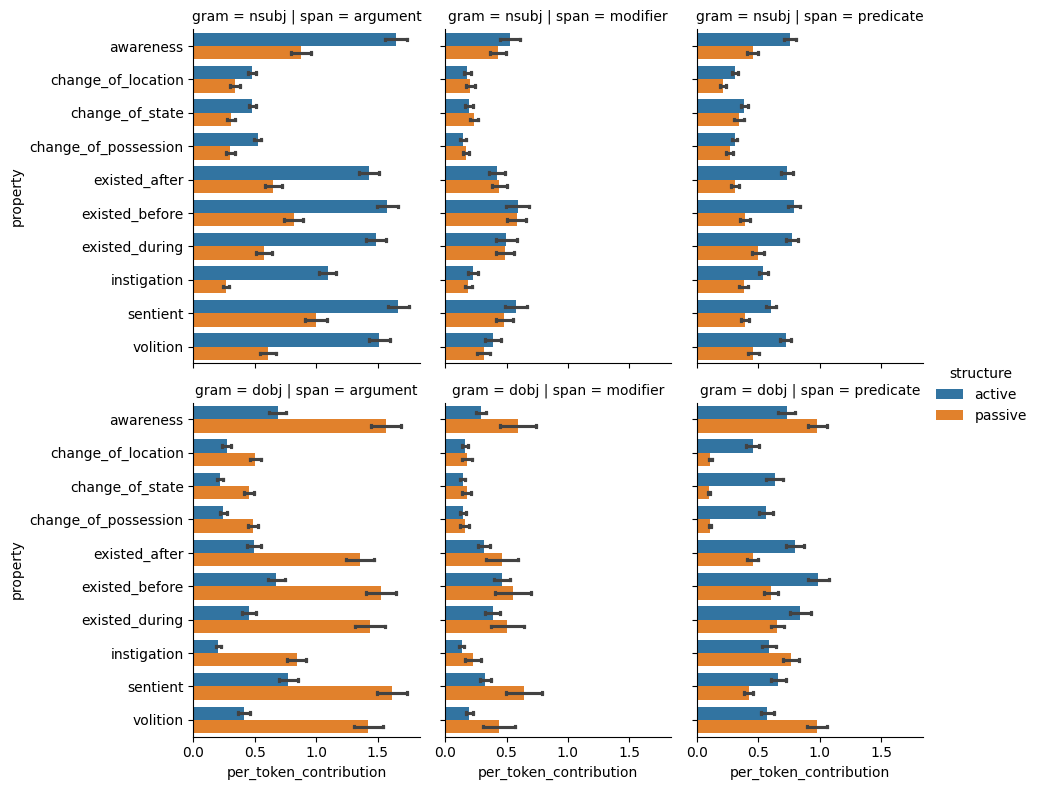

In [15]:
lower, upper = np.nanpercentile(contributions_df["per_token_contribution"].to_numpy(), [5, 95])
print(f"clipping outliers less than {lower} or greater than {upper}")
contributions_df["per_token_contribution"] = contributions_df["per_token_contribution"].apply(
    lambda x: np.clip(x, a_min=lower, a_max=upper)
)

sns.catplot(
    contributions_df.loc[contributions_df["gram"] != "iobj"], col="span", kind="bar", hue="structure", orient="h", row="gram",
    y = "property", x = "per_token_contribution", errorbar="se", height=4, capsize=0.1,
    aspect=0.8)


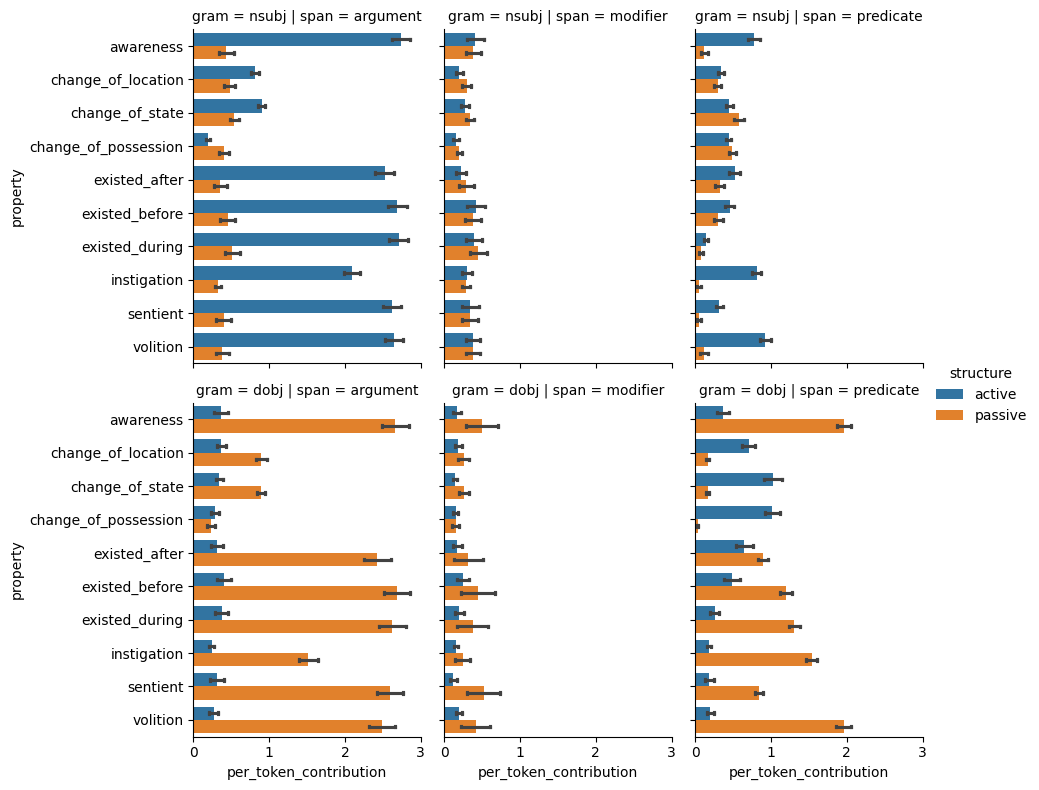

In [16]:
sns.catplot(
    contributions_df.loc[(contributions_df["gram"] != "iobj") & (contributions_df["class"] == "positive")], col="span", kind="bar", hue="structure", orient="h", row="gram",
    y = "property", x = "per_token_contribution", errorbar="se", height=4, capsize=0.1,
    aspect=0.8)


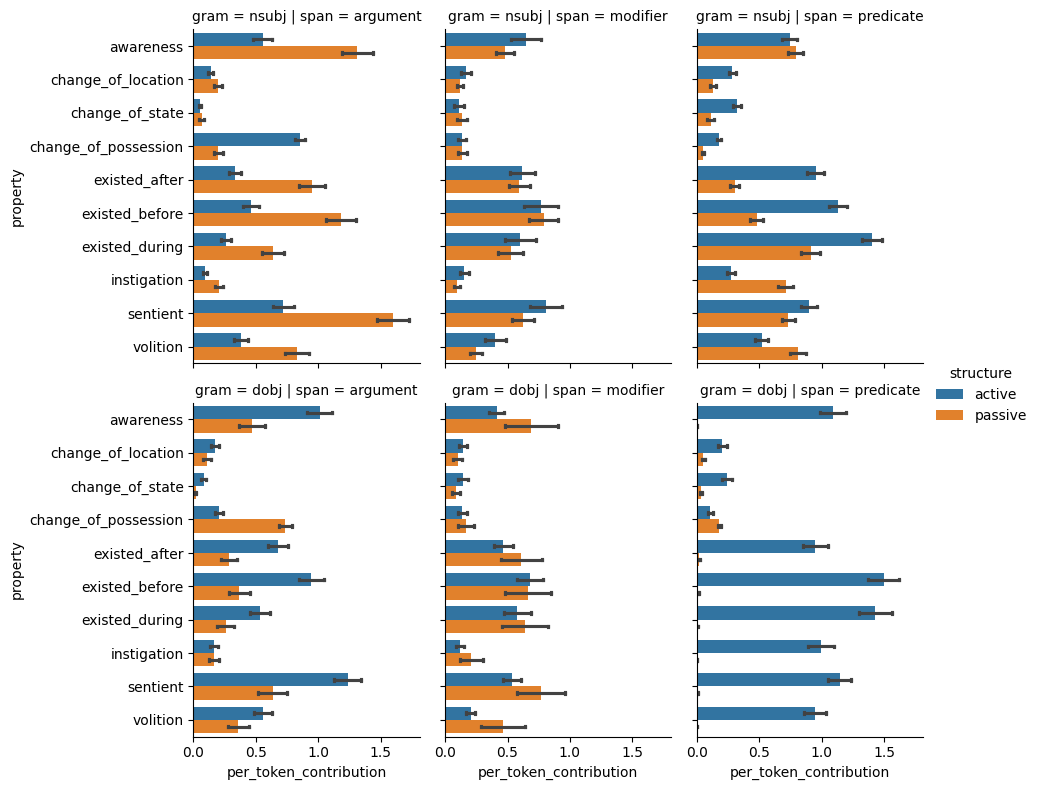

In [17]:
sns.catplot(
    contributions_df.loc[(contributions_df["gram"] != "iobj") & (contributions_df["class"] == "negative")], col="span", kind="bar", hue="structure", orient="h", row="gram",
    y = "property", x = "per_token_contribution", errorbar="se", height=4, capsize=0.1,
    aspect=0.8)


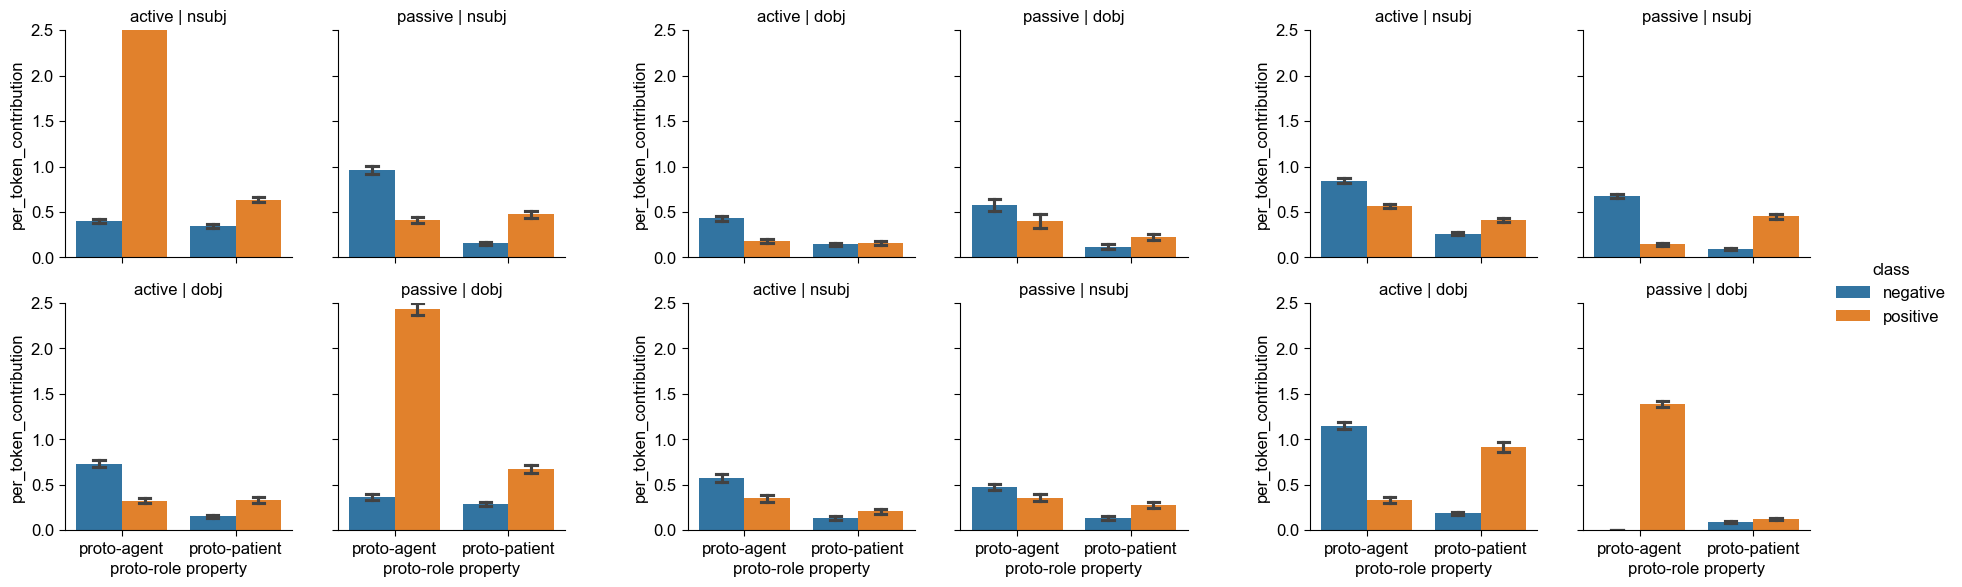

In [20]:
import patchworklib as pw

pw.overwrite_axisgrid()

ax1 = sns.catplot(
    contributions_df.loc[(contributions_df["gram"] != "iobj") & (contributions_df["span"] == "argument")], col="structure", kind="bar", hue="class", orient="v", row="gram",
    x = "proto-role property", y = "per_token_contribution", errorbar="se", height=2.5, capsize=0.2,
    aspect=1, legend=False)
ax1.set_titles("{col_name} | {row_name}")
ax1.set(ylim=(0, 2.5))

ax1 = pw.load_seaborngrid(ax1)

ax2 = sns.catplot(
    contributions_df.loc[(contributions_df["gram"] != "iobj") & (contributions_df["span"] == "modifier")], col="structure", kind="bar", hue="class", orient="v", row="gram",
    x = "proto-role property", y = "per_token_contribution", errorbar="se", height=2.5, capsize=0.2,
    aspect=1, legend=False)
ax2.set_titles("{col_name} | {row_name}")
ax2.set_ylabels("\nper_token_contribution")
ax2.set(ylim=(0, 2.5))

ax2 = pw.load_seaborngrid(ax2)

ax3 = sns.catplot(
    contributions_df.loc[(contributions_df["gram"] != "iobj") & (contributions_df["span"] == "predicate")], col="structure", kind="bar", hue="class", orient="v", row="gram",
    x = "proto-role property", y = "per_token_contribution", errorbar="se", height=2.5, capsize=0.2,
    aspect=1, legend=True, legend_out=True)

ax3.set_titles("{col_name} | {row_name}")
ax3.set_ylabels("\nper_token_contribution")
ax3.set(ylim=(0, 2.5))

ax3 = pw.load_seaborngrid(ax3)

(ax1|ax2|ax3).savefig()


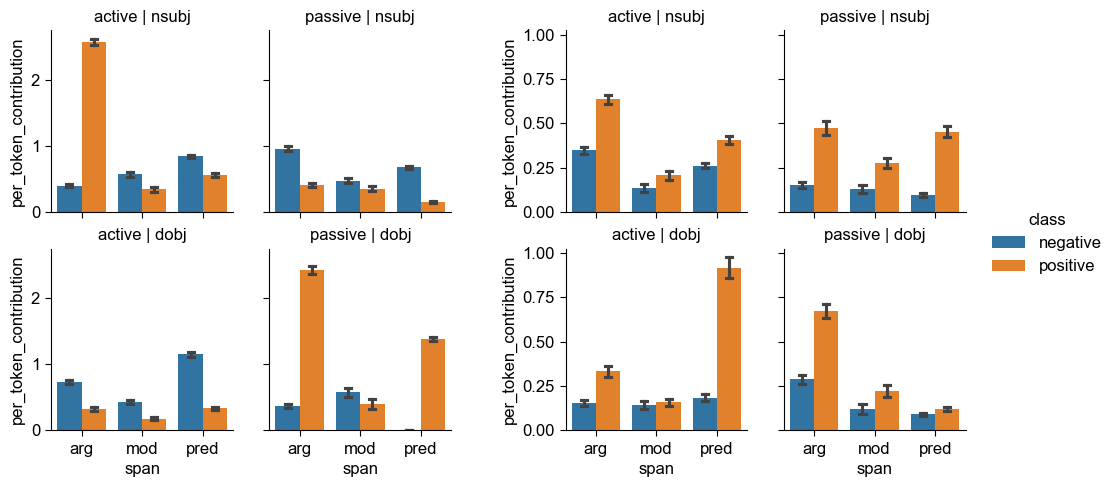

In [21]:
pw.overwrite_axisgrid()

ax1 = sns.catplot(
    contributions_df.loc[(contributions_df["gram"] != "iobj") & (contributions_df["proto-role property"] == "proto-agent")], col="structure", kind="bar", hue="class", orient="v", row="gram",
    x = "span", y = "per_token_contribution", errorbar="se", height=2, capsize=0.2,
    aspect=1, legend=False)
# ax1.set(ylim=(0, 4.5))
ax1.set_titles("{col_name} | {row_name}")
ax1.set_xticklabels(["arg", "mod", "pred"])

ax1 = pw.load_seaborngrid(ax1)

ax2 = sns.catplot(
    contributions_df.loc[(contributions_df["gram"] != "iobj") & (contributions_df["proto-role property"] == "proto-patient")], col="structure", kind="bar", hue="class", orient="v", row="gram",
    x = "span", y = "per_token_contribution", errorbar="se", height=2, capsize=0.2,
    aspect=1, legend=True)
ax2.set_titles("{col_name} | {row_name}")
# ax2.set(ylim=(0, 4.5))
ax2.set_xticklabels(["arg", "mod", "pred"])

ax2 = pw.load_seaborngrid(ax2)

(ax1|ax2).savefig()


### Bias contributions

In [22]:
contributions_df = eval_df.copy(deep=True)

contributions_df["bias_contribution"] = (binary_logits[2]).tolist()
contributions_df[labels] = contributions_df['bias_contribution'].apply(lambda x: pd.Series(np.array(x).T.tolist()))

contributions_df = contributions_df.melt(
    id_vars=["sentence", "index", "contribution", "gram", "structure"], value_vars=labels, value_name="logits",
    var_name="property")
contributions_df[["negative", "positive"]] = contributions_df['logits'].apply(lambda x: pd.Series(np.array(x).T.tolist()))

spans = {
    "arg_nomod": "argument",
    "arg_mod": "modifier",
    "pred": "predicate"
}
contributions_df["span"] = contributions_df["contribution"].apply(
    lambda x: spans["_".join(x.split("_")[:-1])])
contributions_df = contributions_df.melt(id_vars=[ "index", "sentence","span", "property", "gram", "structure"],
                      value_vars=["negative", "positive"],
                      var_name="class", value_name="bias_contribution")

lower, upper = np.nanpercentile(contributions_df["bias_contribution"].to_numpy(), [5, 99])
print(f"clipping outliers less than {lower} or greater than {upper}")

contributions_df["structure"] = contributions_df["structure"].apply(
    lambda x: "_".join(x.split("_")[:-1]))
contributions_df.head()


clipping outliers less than -0.0 or greater than 19.054277086614913


,index,sentence,span,property,gram,structure,class,bias_contribution
0,14299,<a>A girl<a><p> raises<p> her hand.,argument,awareness,nsubj,active,negative,-0.000000
1,14301,A girl<p> raises<p><a> her hand<a>.,argument,awareness,dobj,active,negative,0.381767
2,14303,"""I 'm afraid not"", explains Winston, ""<a> that...",argument,awareness,nsubj,active,negative,-0.000000
3,14305,"In a timid voice,<a> he<a><p> says<p>: ""If an ...",argument,awareness,nsubj,active,negative,-0.000000
4,14307,"""Wonderful!""<a> Winston<a><p> beams<p>.",argument,awareness,nsubj,active,negative,-0.000000


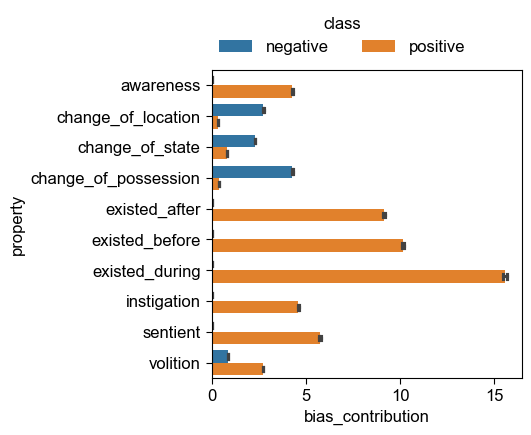

In [23]:
plt.figure(figsize=(4,4))

ax = sns.barplot(
    contributions_df.loc[contributions_df["gram"] != "iobj"], 
    hue="class", y = "property", x = "bias_contribution", errorbar="se",
    capsize=0.3)
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.42, 1), ncol=3,
                title="class", frameon=False)
